# ПЛАН РАБОТЫ

1. загрузка и подготовка данных.
2. обучение моделей 
3. выводы.

In [9]:
# импорт библиотек

import re
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import nltk
from nltk import pos_tag
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

nltk.download('punkt')                       # токенизация
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')  # POS-теггер
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')                     # для лемматизации
nltk.download('omw-1.4')                     # для поддержки WordNet
nltk.download('stopwords')                   # если используешь stopwords

RANDOM_STATE = 42

# убираем предупреждения Pandas Future warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JPB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\JPB\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JPB\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\JPB\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JPB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JPB\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is alread

## загрузка и подготовка данных

In [2]:
try:
    data = pd.read_csv('D:\docs\DS\\toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


столбец `Unnamed: 0` повторяет значения индексов, можно удалить.

In [3]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head(15)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


проверим на пропуски и дубликаты:

In [4]:
print(f'Количество пропусков:\n{data.isna().sum()}')

Количество пропусков:
text     0
toxic    0
dtype: int64


In [5]:
print(f'Количество дубликатов: {data.duplicated().sum()}')

Количество дубликатов: 0


проверим, есть ли дисбаланс в классах:

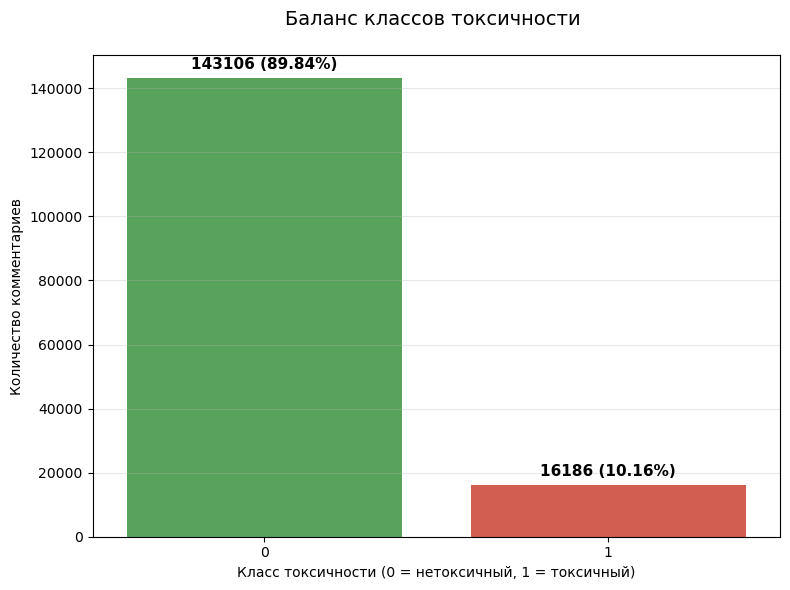

In [6]:
class_counts = data['toxic'].value_counts().sort_index()
class_percents = (class_counts / class_counts.sum() * 100).round(2)

colors = ['#4CAF50', '#E74C3C'] 

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)

plt.title('Баланс классов токсичности \n', fontsize=14)
plt.xlabel('Класс токсичности (0 = нетоксичный, 1 = токсичный)')
plt.ylabel('Количество комментариев')
plt.grid(axis='y', alpha=0.3)

for i, (count, pct) in enumerate(zip(class_counts.values, class_percents.values)):
    plt.text(i, count + class_counts.max() * 0.02, 
             f'{count} ({pct}%)', 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

большая часто отзывов маркированы как нетоксичные - потребуется балансировку классов, учтём это в параметрах моделей.

**нормализация и лемматизация**

In [7]:
stop_words = set(stopwords.words('english'))

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def preprocessing(text):
    
    text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    tokens = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
              for word, tag in pos_tag(word_tokenize(text))] 
    text = ' '.join(tokens) 
    return text

In [10]:
data['lemm_text'] = data['text'].progress_apply(preprocessing)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [11]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [12]:
lemm_data = data.copy()
lemm_data = lemm_data.drop(['text'], axis = 1)

lemm_data.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


мы подготовили тексты для превращения в признаки, подготовим выборки.

In [13]:
y = lemm_data['toxic']
X = lemm_data.drop(['toxic'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(lemm_data, y, test_size=0.1, stratify=y, random_state=RANDOM_STATE)

print('Train data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)

Train data shape: (143362, 2) (143362,)
Test data shape: (15930, 2) (15930,)


в процессе подготовки данных для обучения модели проведены:
* ✅ векторизация, 
* ✅ удаление стоп-слов, 
* ✅ лемматизация
* ✅ разделение на выборки

## Обучение

In [14]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, param_grid = params, cv = 3, n_jobs = -1, scoring = 'f1', verbose = False)
    grid.fit(X_train['lemm_text'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

**Логистическая регрессия**

In [15]:
lr_model = training(LogisticRegression(random_state=RANDOM_STATE), {"model__C":[7, 10]})

Лучший результат: 0.7802397944436724
Лучшие параметры: {'model__C': 10}


**Дерево реешений**

In [16]:
rm_model = training(DecisionTreeClassifier(random_state=RANDOM_STATE), {'model__max_depth':[4,10]})

Лучший результат: 0.5891045352174467
Лучшие параметры: {'model__max_depth': 10}


In [17]:
y_pred = lr_model.predict(X_test['lemm_text'])
print("Результат LogisticRegression", f1_score(y_test, y_pred))

Результат LogisticRegression 0.8021865391185514


метрика качества f1 больше 0.75 &mdash; основное условие задачи выполнено


## Выводы
по ТЗ нам нужно было обучить модель проводить классификацию комментариев: отделять токчичные от нетоксичных. модель логичтической регрессии справилась лучше, чем дерево решений: метрика f1 0.78 у первой модели, у второй &mdash; 0.59. 

на тестовой выборке метрика f1 модели LogisticRegression составила 0.8.